In [84]:
import geopandas as gpd
import pandas as pd
import sys
import os
import gtfs_kit as gtk
import numpy as np
sys.path.insert(0, r'../../../')
from quetzal.io.gtfs_reader import importer
from quetzal.io.gtfs_reader.frequencies import hhmmss_to_seconds_since_midnight 
from quetzal.model import stepmodel


import warnings
warnings.filterwarnings("ignore")

In [85]:
time_range = ['6:00:00', '8:59:00'] # PPAM
#dates = ['20191015'] # the dates must be within the feed start and end dates
#https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.weekday.html
day = 'tuesday'
day_dict = {
    'monday': 0,
    'tuesday': 1,
    'wednesday': 2,
    'thursday': 3,
    'friday': 4,
    'saturday': 5,
    'sunday': 6
}
selected_day = day_dict[day]
selected_day

1

In [86]:
# GTFS are read recursively between each ancestor
files=[]
gtfs_folder = 'gtfs/cmm/'
if os.path.exists(gtfs_folder):
    for filename in filter(lambda x: x[-4:] == '.zip', os.listdir(gtfs_folder)):
        files.append(gtfs_folder+filename)

#files = files[0:1]
files=[files[2]]
files

['gtfs/cmm/stl.zip']

In [4]:
'''
files = [
    "https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-unknown-via-rail-canada-gtfs-735.zip?alt=media",
    "https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-quebec-exo-sorel-varennes-gtfs-741.zip?alt=media",
    "https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-quebec-exo-sud-ouest-gtfs-742.zip?alt=media",
    "https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-quebec-exo-la-presquile-gtfs-743.zip?alt=media"
]
files = ["https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-british-columbia-translink-vancouver-gtfs-1222.zip?alt=media"]
'''

'\nfiles = [\n    "https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-unknown-via-rail-canada-gtfs-735.zip?alt=media",\n    "https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-quebec-exo-sorel-varennes-gtfs-741.zip?alt=media",\n    "https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-quebec-exo-sud-ouest-gtfs-742.zip?alt=media",\n    "https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-quebec-exo-la-presquile-gtfs-743.zip?alt=media"\n]\nfiles = ["https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-british-columbia-translink-vancouver-gtfs-1222.zip?alt=media"]\n'

# import

In [87]:
feeds=[]
for file in files:
    print('Importing {f}.zip'.format(f=file))
    feeds.append(importer.GtfsImporter(path=file, dist_units='m'))


Importing gtfs/cmm/stl.zip.zip


In [88]:
for i in range(len(feeds)):
    print(files[i])
    if 'agency_id' not in feeds[i].routes:
        print(f'add agency_id to routes in {files[i]}')
        feeds[i].routes['agency_id'] = feeds[i].agency['agency_id'].values[0]
    
    if 'pickup_type' not in feeds[i].stop_times:
        print(f'picjup_type missing in stop_times. set to 0 in {files[i]}')
        feeds[i].stop_times['pickup_type'] = 0
    
    if 'drop_off_type' not in feeds[i].stop_times:
        print(f'drop_odd_type missing in stop_times. set to 0 in {files[i]}')
        feeds[i].stop_times['drop_off_type'] = 0
        
    if 'parent_station' not in feeds[i].stops:
        print(f'parent_station missing in stops. set to NaN in {files[i]}')
        feeds[i].stops['parent_station'] = np.nan
        
    feeds[i].stop_times['pickup_type'].fillna(0, inplace=True)
    feeds[i].stop_times['drop_off_type'].fillna(0, inplace=True)
    feeds[i].stop_times['arrival_time'] = feeds[i].stop_times['departure_time']

gtfs/cmm/stl.zip
parent_station missing in stops. set to NaN in gtfs/cmm/stl.zip


# filtres

In [89]:

dates =[]
for feed in feeds:
    min_date = feed.calendar['start_date'].unique().min()
    max_date = feed.calendar['end_date'].unique().max()
    # get date range 
    s = pd.date_range(min_date, max_date, freq='D').to_series()
    # get dayofweek selected and take first one
    s = s[s.dt.dayofweek==selected_day][0]
    # format  ex: ['20231011'] and append
    dates.append([f'{s.year}{str(s.month).zfill(2)}{str(s.day).zfill(2)}'])


In [90]:
feeds_t = []

for i, feed in enumerate(feeds):
    feed_t = feed.restrict(dates=dates[i], time_range=time_range)
    if len(feed_t.trips) > 0:
        feeds_t.append(feed_t)

In [91]:
print('add shape_dist_traveled to shapes')
for feed in feeds_t:
    if 'shape_dist_traveled' not in feed.shapes.columns:
        feed.append_dist_to_shapes()

add shape_dist_traveled to shapes


In [92]:
for feed in feeds_t:
    if 'shape_dist_traveled' not in feed.stop_times.columns:
        feed.append_dist_to_stop_times_fast()
    else:
        nan_sequence=feed.stop_times[feed.stop_times['shape_dist_traveled'].isnull()]['stop_sequence'].unique()
        if all(seq==1 for seq in nan_sequence):
            feed.stop_times['shape_dist_traveled'] = feed.stop_times['shape_dist_traveled'].fillna(0)
        else:
            feed.append_dist_to_stop_times_fast()
for feed in feeds_t:            
    if feed.stop_times['shape_dist_traveled'].max() < 100:
        print(f'convert to meters')
        feed.dist_units = 'km'
        feed = gtk.convert_dist(feed, new_dist_units='m')


In [93]:
%%time
feeds_frequencies = []

for i in range(len(feeds_t)):
    print(i)
    feed_s = feeds_t[i].copy()
    feed_s.group_services()

    feed_s.build_stop_clusters(distance_threshold=50)
    feed_s.build_patterns(on='cluster_id')

    feed_frequencies = feed_s.convert_to_frequencies(time_range=time_range)
    shapes = feed_frequencies.shapes is not None
    feed_frequencies.build_links_and_nodes(log=False, 
                                           shape_dist_traveled=True, 
                                           from_shape=shapes, 
                                           stick_nodes_on_links=shapes,
                                           num_cores=1,
                                           keep_origin_columns=['departure_time','pickup_type'],
                                           keep_destination_columns=['arrival_time','drop_off_type'])
    feeds_frequencies.append(feed_frequencies)

0
CPU times: user 19.7 s, sys: 14.5 ms, total: 19.7 s
Wall time: 19.7 s


In [94]:
%%time

for i in range(len(feeds_t)):
    print(i)
    feed_s = feeds_t[i].copy()
    feed_s.group_services()

    feed_s.build_stop_clusters(distance_threshold=50)
    feed_s.build_patterns(on='cluster_id')

    feed_frequencies = feed_s.convert_to_frequencies(time_range=time_range)
    shapes = feed_frequencies.shapes is not None
    feed_frequencies.build_links_and_nodes(log=False, 
                                           shape_dist_traveled=True, 
                                           from_shape=shapes, 
                                           stick_nodes_on_links=shapes,
                                           num_cores=4,
                                           keep_origin_columns=['departure_time','pickup_type'],
                                           keep_destination_columns=['arrival_time','drop_off_type'])
    feeds_frequencies.append(feed_frequencies)

0
CPU times: user 1.77 s, sys: 87.7 ms, total: 1.85 s
Wall time: 7.33 s


In [95]:
test1 = feeds_frequencies[0].links.copy().set_index('trip_id').sort_index()[['geometry']]
test2 = feeds_frequencies[1].links.copy().set_index('trip_id').sort_index()[['geometry']]
test1 = test1.reset_index()
test1.index.name='index'
test2 = test2.reset_index()
test2.index.name='index'

In [96]:
test1['val']=1
test2['val']=2

<Axes: >

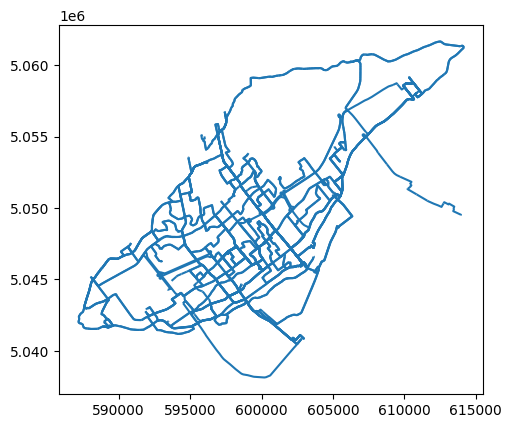

In [97]:
test1.plot()

In [55]:
test1.to_crs(4326).to_file('1.geojson',driver='GeoJSON')
test2.to_crs(4326).to_file('2.geojson',driver='GeoJSON')

In [57]:
test1

,trip_id,geometry,val
index,,,
0,JUIN1912E_0,"LINESTRING (602837.612 5045990.303, 602742.043...",1
1,JUIN1912E_0,"LINESTRING (603082.441 5046055.560, 603101.598...",1
2,JUIN1912E_0,"LINESTRING (603101.598 5046029.983, 603184.747...",1
3,JUIN1912O_0,"LINESTRING (603642.132 5046576.100, 603643.759...",1
4,JUIN1912O_0,"LINESTRING (603482.623 5046253.107, 603462.160...",1
...,...,...,...
4792,JUIN19942O_0,"LINESTRING (607305.974 5055316.730, 607180.345...",1
4793,JUIN19942O_0,"LINESTRING (610827.039 5058507.902, 610822.522...",1
4794,JUIN19942O_0,"LINESTRING (609742.429 5057108.324, 609697.964...",1


In [98]:
mapping = {0:'tram', 1:'subway', 2:'rail', 3:'bus',4:'ferry',5:'cable_car',6:'gondola',7:'funicular', 700:'bus', 1501:'taxi'}
retire = ['taxi']
for feed_frequencies in feeds_frequencies:
    feed_frequencies.links['route_type'] = feed_frequencies.links['route_type'].apply(
        lambda t: mapping.get(t, np.nan)
    )
    
    assert not any(feed_frequencies.links['route_type'].isna())
    feed_frequencies.links = feed_frequencies.links[~feed_frequencies.links['route_type'].isin(retire)]

for feed_frequencies in feeds_frequencies:
    feed_frequencies.links.loc[feed_frequencies.links['time'] == 0,'time'] = 1.0

# create Model

In [99]:
columns=['trip_id','route_id','agency_id','direction_id','a','b', 'shape_dist_traveled',
                                    'link_sequence','time','headway','pickup_type', 'drop_off_type',
                                    'route_short_name','route_type','route_color','geometry']

In [100]:
sm = stepmodel.StepModel(epsg=4326, coordinates_unit='meter')

links_concat = []; nodes_concat = []
for feed_frequencies in feeds_frequencies:
    links_concat.append(feed_frequencies.links)
    nodes_concat.append(feed_frequencies.nodes)
if len(links_concat)==0:
    print('gg')
    
sm.links = pd.concat(links_concat)
for col in columns:
    if col not in sm.links.columns:
        sm.links[col] = np.nan
        
sm.links = sm.links[columns]
sm.nodes = pd.concat(nodes_concat)[['stop_id','stop_name','stop_code','geometry']]

sm.nodes = sm.nodes.reset_index(drop=True).sort_index()
sm.links = sm.links.reset_index(drop=True).sort_index()


sm.nodes.loc[sm.nodes['stop_code'].isna(),'stop_code'] = sm.nodes.loc[sm.nodes['stop_code'].isna(),'stop_id'] 
sm.nodes.drop_duplicates(subset=['stop_id'], inplace=True)

sm.links['trip_id'] = sm.links['agency_id'] +'_' +sm.links['trip_id']
sm.links['route_id'] = sm.links['agency_id'] +'_' +sm.links['route_id']

sm.links = sm.links.sort_values(['route_type','trip_id']).reset_index(drop=True)

dnodes = ('node_' +sm.nodes.reset_index().set_index('stop_id')['index'].astype(str)).to_dict()
sm.nodes.index = 'node_' +sm.nodes.index.astype(str)

sm.links.index = 'link_' +sm.links.index.astype(str)

sm.links['a'] = sm.links['a'].apply(lambda a: dnodes.get(a))
sm.links['b'] = sm.links['b'].apply(lambda a: dnodes.get(a))

sm.links.drop_duplicates(subset=['trip_id','link_sequence'], inplace=True)

# Tag route with only one trip
time_slot = np.diff([hhmmss_to_seconds_since_midnight(time) for time in time_range])[0]
sm.links.loc[(time_slot/sm.links['headway']) < 2.0, 'headway'] = np.nan

sm.links = sm.links.to_crs(4326)
sm.nodes = sm.nodes.to_crs(4326)

In [25]:
gpd.GeoDataFrame(columns=['feature'], geometry='feature',crs=4326).to_file('test.geojson',driver='GeoJSON')

# test

In [72]:
# lambda price for 10GB per hours
price = 0.0000166667*60*60*10
price

0.6000012

In [74]:
price*20

12.000024

In [75]:
400_000/60/60/10 #heures gratuites a 10gb.

11.11111111111111

In [76]:
# with EB EC2 t3.xlarge:
# 4 cores,m 16bg
price = 0.1856 #per hour

In [77]:
price*30

5.568

In [ ]:
#plan de match:
si on a pas de shape_dist_traveled. prendre le temps avec les stop_time comme dist.
(la methode 2 de gtfs_kit quand ca marche pas)

anyway. on va recalculer avec le shape avec la methode a simon f.

In [202]:
test

<function __main__.parallel.<locals>.decorator.<locals>.wrapper(*args, **kwargs)>

In [271]:
from parallel import parallel

In [424]:
from multiprocessing import Process, Manager

def parallel(loop_arg,num_cores=2):
    def decorator(func):
        def wrapper(**kwargs):
            print(num_cores)
            if num_cores==1:
                return func(**kwargs)
            else:
                ls = kwargs.pop(loop_arg)
                chunk_length =  round(len(ls)/ num_cores)
                chunks = [ls[j: j + chunk_length] for j in range(0, len(ls), chunk_length)]
                
                def process_wrapper(chunk, kwargs, result_list, index):
                    kwargs[loop_arg] = chunk
                    result = func(**kwargs)
                    result_list[index] = result
                manager = Manager()
                result_list = manager.list([None] * len(chunks))
                processes = []
                for i, chunk in enumerate(chunks):
                    process = Process(target=process_wrapper, args=(chunk, kwargs, result_list, i))
                    process.start()
                    processes.append(process)
                for process in processes:
                    process.join()
                # Convert the manager list to a regular list for easier access
                result_list = np.array(result_list)
                if result_list.ndim==1:
                    return result_list
                else:
                    tuple_len = result_list.shape[1]
                    return tuple(res[:][i] for i in range(tuple_len))
                 
        return wrapper
    return decorator





In [425]:
@parallel(num_cores=2,loop_arg='trip_list')
def test(links,trip_list,constant):
    result = []
    for trip in trip_list:
        links = sm.links[sm.links['trip_id']==trip]
        res = links['headway'].values.sum() + constant
        result.append((trip,res))
    return result,'yes'

In [426]:
trip_list =  sm.links['trip_id'].unique()
# calling the function
res1,res2 = test(links=sm.links, trip_list=trip_list, constant=44)

2


In [413]:
res.shape[1]

2